In [4]:
import pandas as pd
import numpy
import numpy as np

# For modeling the stocks
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, RobustScaler, QuantileTransformer

import matplotlib.pyplot as plt
from scipy.stats import norm, probplot, t

# Import dart APIs
from darts import TimeSeries
from darts.models import RNNModel, TFTModel
from darts.utils.likelihood_models import GaussianLikelihood, QuantileRegression
from darts.dataprocessing.transformers import Scaler
from darts.dataprocessing import Pipeline
from darts.metrics import mape, mse, r2_score
from darts.utils.losses import MAELoss, MapeLoss
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import Callback
from torch.nn import MSELoss

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf

# For time stamps
from datetime import datetime, timedelta

plt.style.use("fivethirtyeight")
%matplotlib inline



### Predicting the closing price of Bitcoin:

### Checking Data

In [12]:
# Get the stock quote
df2020 = pd.read_csv('BTCUSDT_Binance_futures_2020_minute.csv', parse_dates = True, index_col = 'date', usecols=['date', 'open', 'high', 'low', 'close', 'Volume USDT'])
df2021 = pd.read_csv('BTCUSDT_Binance_futures_2021_minute.csv', parse_dates = True, index_col = 'date', usecols=['date', 'open', 'high', 'low', 'close', 'Volume USDT'])
df2022 = pd.read_csv('BTCUSDT_Binance_futures_2022_minute.csv', parse_dates = True, index_col = 'date', usecols=['date', 'open', 'high', 'low', 'close', 'Volume USDT'])
#invert dataframes and sort by dates
df2020 = df2020.reindex(index=df2020.index[::-1])
df2021 = df2021.reindex(index=df2021.index[::-1])
df2022 = df2022.reindex(index=df2022.index[::-1])
# Combine three dataframe together
frames = [df2020, df2021, df2022]
df = pd.concat(frames)
# Show the data
df

,open,high,low,close,Volume USDT
date,,,,,
2020-01-01 00:01:00,7182.43,7182.44,7178.75,7179.01,5.091458e+05
2020-01-01 00:02:00,7179.01,7179.01,7175.25,7177.93,7.135396e+05
2020-01-01 00:03:00,7177.77,7182.60,7177.00,7181.11,4.977934e+05
2020-01-01 00:04:00,7179.10,7179.10,7172.94,7175.25,6.986274e+05
2020-01-01 00:05:00,7174.71,7177.14,7173.28,7175.61,2.419795e+05
...,...,...,...,...,...
2022-08-23 00:15:00,21375.60,21380.10,21340.50,21342.00,1.491091e+07
2022-08-23 00:16:00,21341.60,21354.90,21335.20,21345.30,1.446299e+07
2022-08-23 00:17:00,21345.30,21373.60,21344.00,21363.90,8.929279e+06


In [13]:
# Checking data
df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close'}, inplace=True)
df.isna().sum()

Open           0
High           0
Low            0
Close          0
Volume USDT    0
dtype: int64

In [14]:
# remove timezone
df.index = df.index.tz_localize(None)
df

,Open,High,Low,Close,Volume USDT
date,,,,,
2020-01-01 00:01:00,7182.43,7182.44,7178.75,7179.01,5.091458e+05
2020-01-01 00:02:00,7179.01,7179.01,7175.25,7177.93,7.135396e+05
2020-01-01 00:03:00,7177.77,7182.60,7177.00,7181.11,4.977934e+05
2020-01-01 00:04:00,7179.10,7179.10,7172.94,7175.25,6.986274e+05
2020-01-01 00:05:00,7174.71,7177.14,7173.28,7175.61,2.419795e+05
...,...,...,...,...,...
2022-08-23 00:15:00,21375.60,21380.10,21340.50,21342.00,1.491091e+07
2022-08-23 00:16:00,21341.60,21354.90,21335.20,21345.30,1.446299e+07
2022-08-23 00:17:00,21345.30,21373.60,21344.00,21363.90,8.929279e+06


In [15]:
# Slicing data for faster training
# Slicing rows in data frame
df = df.loc['2022-6-1':]

# data frame after slicing
df

,Open,High,Low,Close,Volume USDT
date,,,,,
2022-06-01 00:00:00,31797.9,31818.9,31794.6,31818.9,4.790929e+06
2022-06-01 00:01:00,31818.9,31836.8,31814.5,31828.7,6.261005e+06
2022-06-01 00:02:00,31828.6,31850.0,31815.0,31844.2,6.289866e+06
2022-06-01 00:03:00,31844.2,31847.4,31832.1,31834.9,2.573526e+06
2022-06-01 00:04:00,31834.9,31842.5,31830.4,31831.7,2.172423e+06
...,...,...,...,...,...
2022-08-23 00:15:00,21375.6,21380.1,21340.5,21342.0,1.491091e+07
2022-08-23 00:16:00,21341.6,21354.9,21335.2,21345.3,1.446299e+07
2022-08-23 00:17:00,21345.3,21373.6,21344.0,21363.9,8.929279e+06


In [16]:
df['Return'] = df['Close'].pct_change()
df

C:\Users\HKamkar\AppData\Local\Temp\ipykernel_21444\278150838.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'] = df['Close'].pct_change()


,Open,High,Low,Close,Volume USDT,Return
date,,,,,,
2022-06-01 00:00:00,31797.9,31818.9,31794.6,31818.9,4.790929e+06,NaN
2022-06-01 00:01:00,31818.9,31836.8,31814.5,31828.7,6.261005e+06,0.000308
2022-06-01 00:02:00,31828.6,31850.0,31815.0,31844.2,6.289866e+06,0.000487
2022-06-01 00:03:00,31844.2,31847.4,31832.1,31834.9,2.573526e+06,-0.000292
2022-06-01 00:04:00,31834.9,31842.5,31830.4,31831.7,2.172423e+06,-0.000101
...,...,...,...,...,...,...
2022-08-23 00:15:00,21375.6,21380.1,21340.5,21342.0,1.491091e+07,-0.001567
2022-08-23 00:16:00,21341.6,21354.9,21335.2,21345.3,1.446299e+07,0.000155
2022-08-23 00:17:00,21345.3,21373.6,21344.0,21363.9,8.929279e+06,0.000871


In [17]:
# Checking data
df.isna().sum()
# first row has a NA return. I set it to 0 manually
df = df.fillna(0)
df.isna().sum()

Open           0
High           0
Low            0
Close          0
Volume USDT    0
Return         0
dtype: int64

In [ ]:
# Creating a new feature about price

low_low=[]

for row in range(len(df)):
    if df.iloc[row-1, 2] > df.iloc[row, 2]:
        low_low.append(0)
        
    elif (df.iloc[row-1, 2] < df.iloc[row, 2]):
        low_low.append(1)
        
    elif (df.iloc[row-1, 2] == df.iloc[row, 2]):
        low_low.append(-1)
        
low_low = np.array(low_low)        
low_low = np.transpose(low_low).reshape(-1,1)
df['Custom lows'] = low_low
df

In [ ]:
# Creating a new feature about price

high_high=[]

for row in range(len(df)):
    if df.iloc[row-1, 1] > df.iloc[row, 1]:
        high_high.append(0)
        
    elif (df.iloc[row-1, 1] < df.iloc[row, 1]):
        high_high.append(1)
        
    elif (df.iloc[row-1, 1] == df.iloc[row, 1]):
        high_high.append(-1)
        
high_high = np.array(high_high)        
high_high = np.transpose(high_high).reshape(-1,1)
df['Custom highs'] = high_high
df

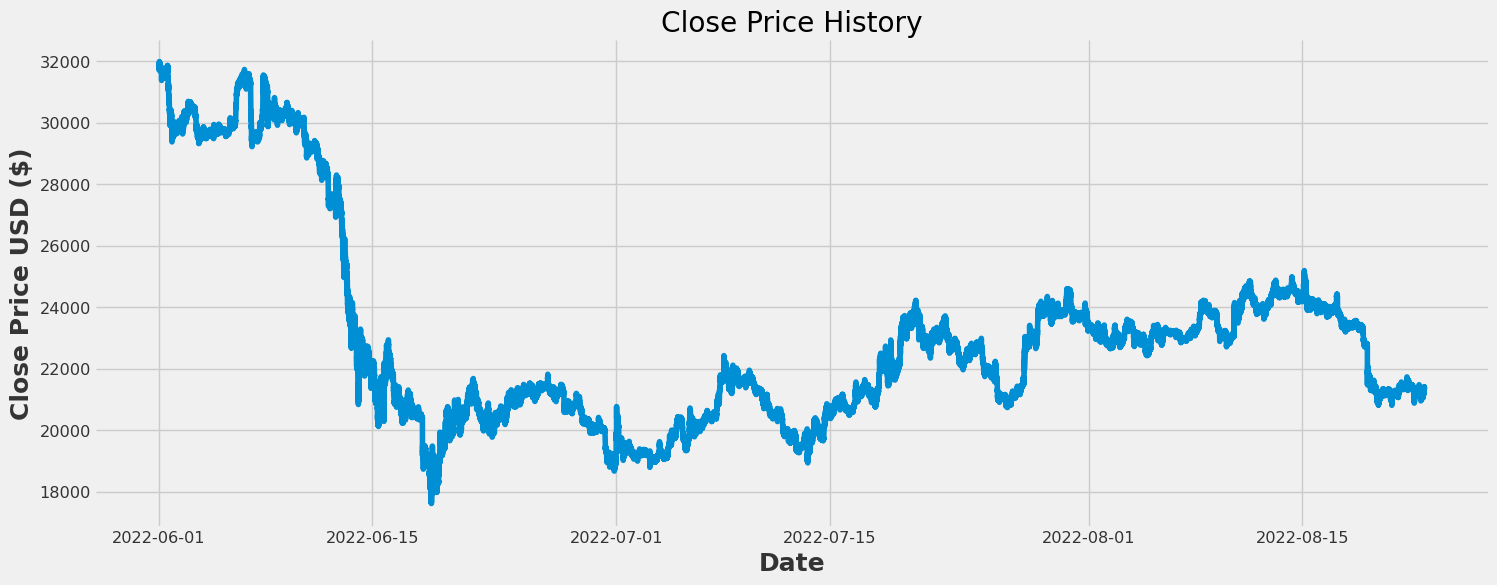

In [18]:
# Plot close price history
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
#plt.hist(df['Volume']);
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

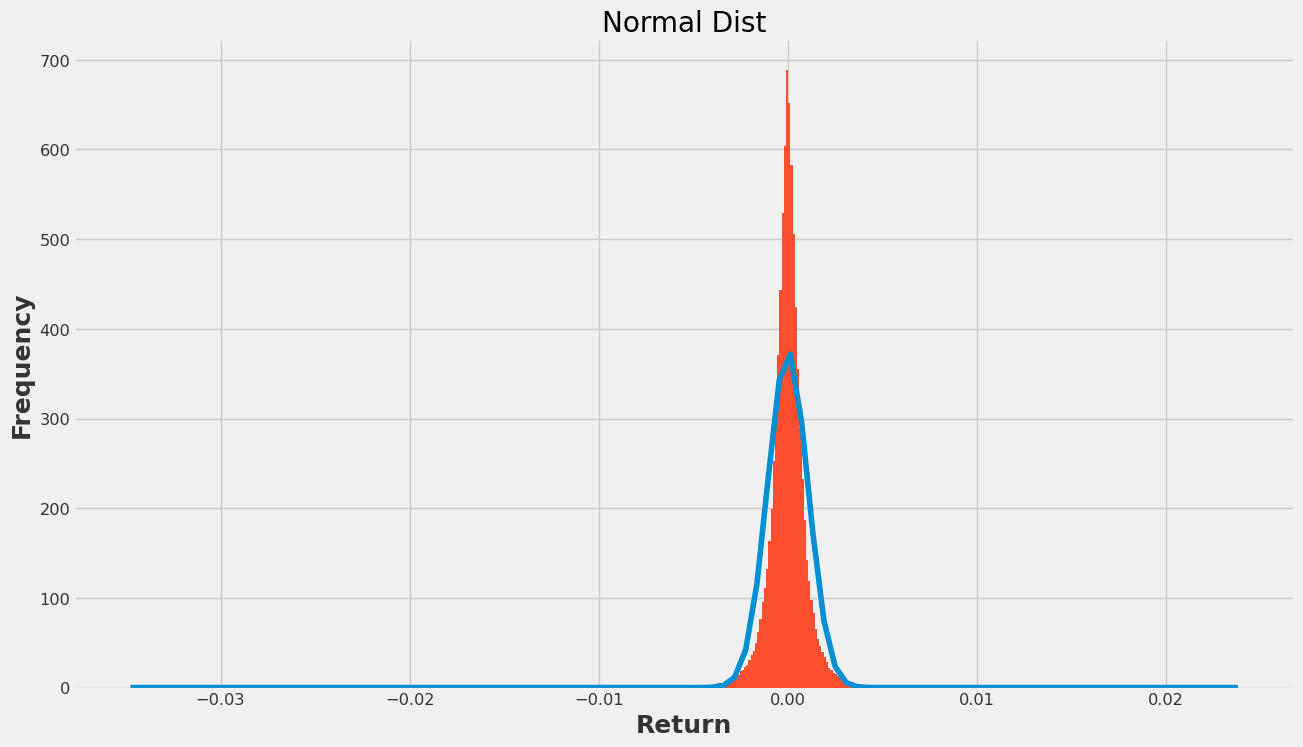

In [19]:
x_list = np.linspace(
                    df['Return'].min(),
                    df['Return'].max(),
                    100
                    )

y_list = norm.pdf(x_list, loc=df['Return'].mean(), scale=df['Return'].std())

plt.figure(figsize=(14,8))
plt.title('Normal Dist')
plt.xlabel('Return', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.plot(x_list,y_list);
plt.hist(df['Return'], bins=500,density=True);

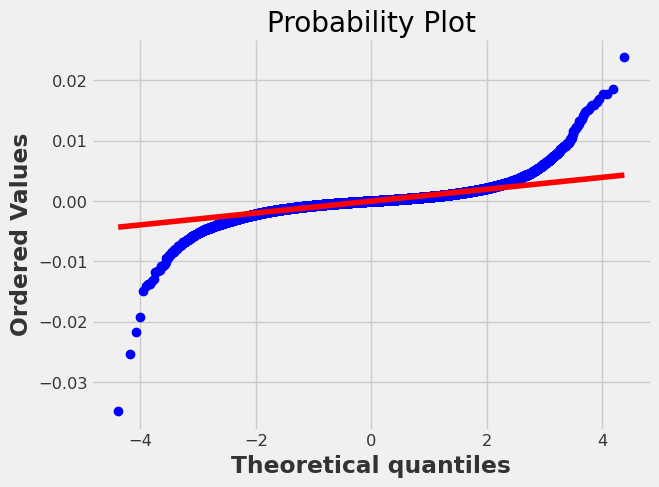

In [20]:
probplot(df['Return'],dist='norm',fit= True,plot=plt);

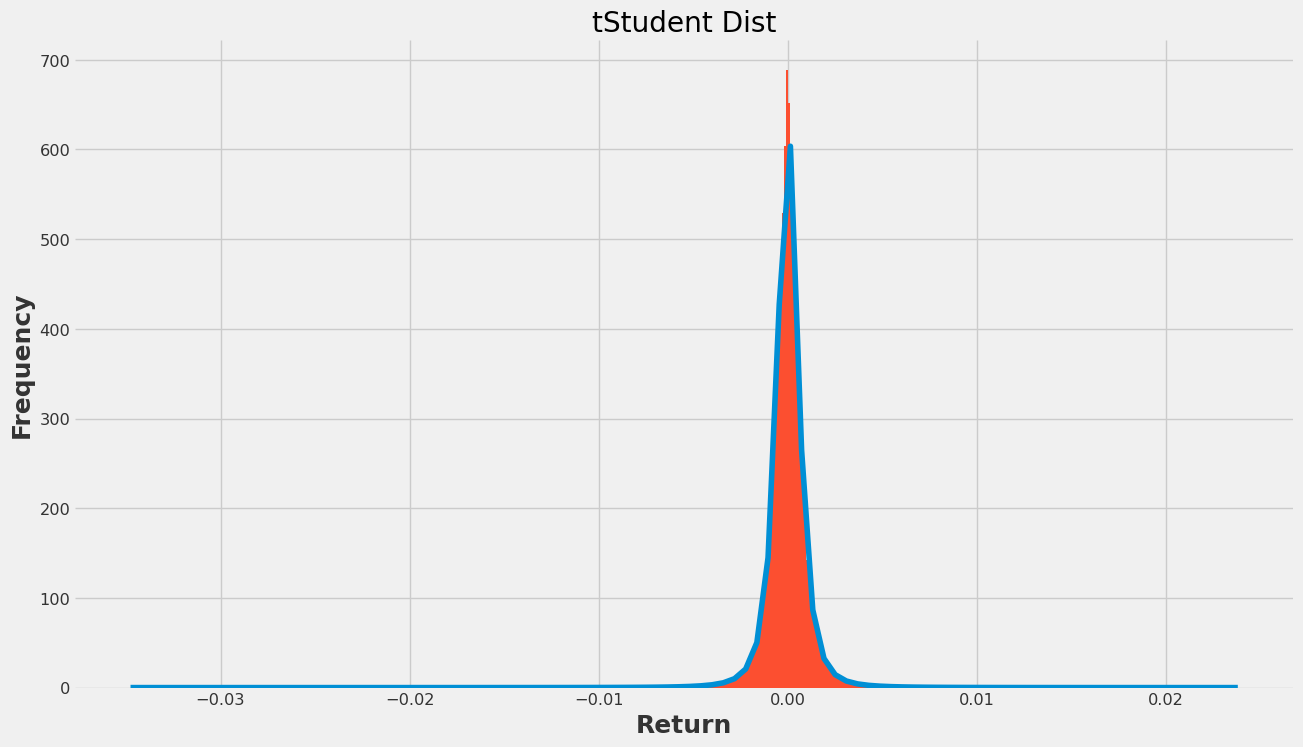

In [21]:
x_list = np.linspace(
                    df['Return'].min(),
                    df['Return'].max(),
                    100
                    )

params = t.fit(df['Return'].dropna())
degree_of_freedom, loc, scale = params

y_list = t.pdf(x_list, degree_of_freedom, loc, scale)

plt.figure(figsize=(14,8))
plt.title('tStudent Dist')
plt.xlabel('Return', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.plot(x_list,y_list);
plt.hist(df['Return'], bins=500,density=True);

### Processing data

In [22]:
# features list
features = ['Return']
feature_size = len(features)
feature_size

1

In [23]:
# Create a new dataframe with only the 'Close' and 'volume' column 
df = df.filter(features)
print(type(df))
df

<class 'pandas.core.frame.DataFrame'>


,Return
date,
2022-06-01 00:00:00,0.000000
2022-06-01 00:01:00,0.000308
2022-06-01 00:02:00,0.000487
2022-06-01 00:03:00,-0.000292
2022-06-01 00:04:00,-0.000101
...,...
2022-08-23 00:15:00,-0.001567
2022-08-23 00:16:00,0.000155
2022-08-23 00:17:00,0.000871


In [24]:
#bh = pd.tseries.offsets.BusinessHour(start='9:30', end='15:30')
data = TimeSeries.from_dataframe(df, fill_missing_dates=True, freq='min')
print(data)

<TimeSeries (DataArray) (date: 119540, component: 1, sample: 1)>
array([[[ 0.        ]],

       [[ 0.00030799]],

       [[ 0.00048698]],

       ...,

       [[ 0.00087139]],

       [[ 0.00122637]],

       [[-0.00036933]]])
Coordinates:
  * date       (date) datetime64[ns] 2022-06-01 ... 2022-08-23T00:19:00
  * component  (component) object 'Return'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


In [25]:
# Get the number of rows to train the model on (80% of total data)
x_train, x_test = data.split_before(0.8)
print(x_train.n_timesteps)
print(x_test.n_timesteps)

95631
23909


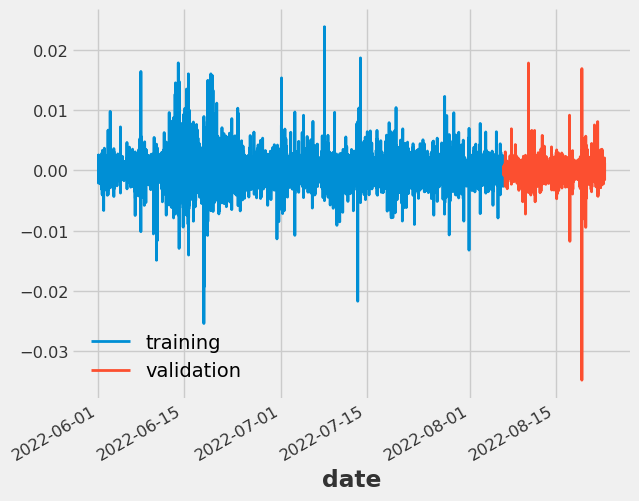

In [26]:
x_train.plot(label="training")
x_test.plot(label="validation")

In [27]:
# Pipeline
scaler1 = RobustScaler()
scaler2 = MinMaxScaler()
pipeline = Pipeline([Scaler(scaler1),  Scaler(scaler2)])
rescaled_train = pipeline.fit_transform(x_train)
rescaled_test = pipeline.transform(x_test)
rescaled_data = pipeline.transform(data)

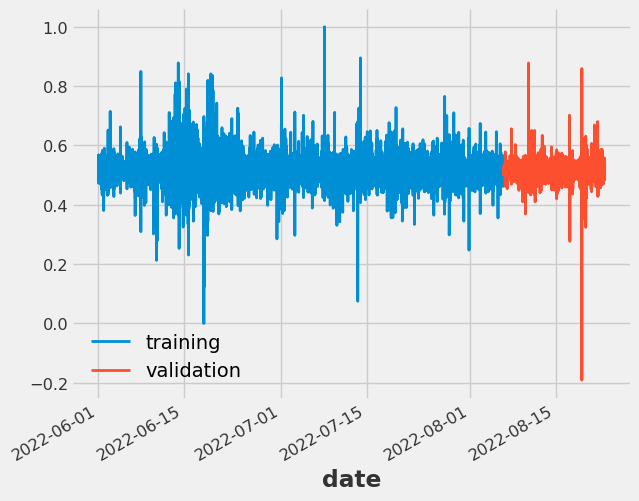

In [28]:
rescaled_train.plot(label="training")
rescaled_test.plot(label="validation")

### Model using simple RNN model as baseline

#### Callbacks

In [29]:
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pl_bolts.callbacks import PrintTableMetricsCallback

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
early_stopping_callback = EarlyStopping(
    monitor='train_loss',
    patience=5,
    min_delta=0.05,
    mode='min',
)

# saves a file like: my/path/epoch=2-val_loss=0.02-other_metric=0.03.ckpt
model_checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                            save_top_k=5,
                                            dirpath='saved_model',
                                            filename='{epoch}-{val_loss:.2f}-{other_metric:.2f}',
                                            )

lr_monitor = LearningRateMonitor(logging_interval='step')

metric_callback = PrintTableMetricsCallback()

### Create covariate

In [30]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# create year, month and integer index covariate series
training_cutoff = pd.Timestamp(rescaled_train.end_time())
covariates = datetime_attribute_timeseries(data, attribute='day', one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(data, attribute='hour', one_hot=False)
)
covariates = covariates.stack(
    datetime_attribute_timeseries(data, attribute='minute', one_hot=False)
)

covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=data.time_index,
        values=np.arange(len(data)),
        columns=['linear_increase'],
    )
)
covariates = covariates.astype(np.float32)

# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)

In [31]:
covariates.to_csv('cov.csv')

In [32]:
from pytorch_lightning.callbacks import ModelSummary

# Create RNN model

rnn_model = RNNModel(
    input_chunk_length=20,
    model='GRU',
    hidden_dim=25,
    n_rnn_layers=2,
    dropout=0,
    n_epochs=2,
    optimizer_kwargs={'lr':1e-3},
    pl_trainer_kwargs={'callbacks': [early_stopping_callback, model_checkpoint_callback, lr_monitor]},
    training_length=50,
    #likelihood=GaussianLikelihood(),
    #loss_fn=MSELoss(),
    force_reset=True,
    save_checkpoints=True,
    log_tensorboard=True,
)

In [33]:
# Fit RNN model
rnn_model.fit(rescaled_train, val_series=rescaled_test, future_covariates=covariates_transformed, val_future_covariates=covariates_transformed, verbose=True)

C:\Users\HKamkar\.conda\envs\darts\lib\site-packages\darts\timeseries.py:4079: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  if isinstance(time_idx, pd.Int64Index) and not isinstance(
2022-08-24 15:40:41 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-08-24 15:40:41 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-08-24 15:40:41 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
2022-08-24 15:40:41 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | GRU              | 6.3 K 
4 | V             | Linear           | 26    
-

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [42]:
def eval_model(model,n):
    pred_series = model.predict(n, future_covariates=covariates_transformed)
    #pred_series = pipeline.inverse_transform(pred_series)
    plt.figure(figsize=(10, 6))
    #rescaled_data[: pred_series.end_time()].plot(label="actual")
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, rescaled_test)))
    plt.legend()


Predicting: 2987it [00:00, ?it/s]

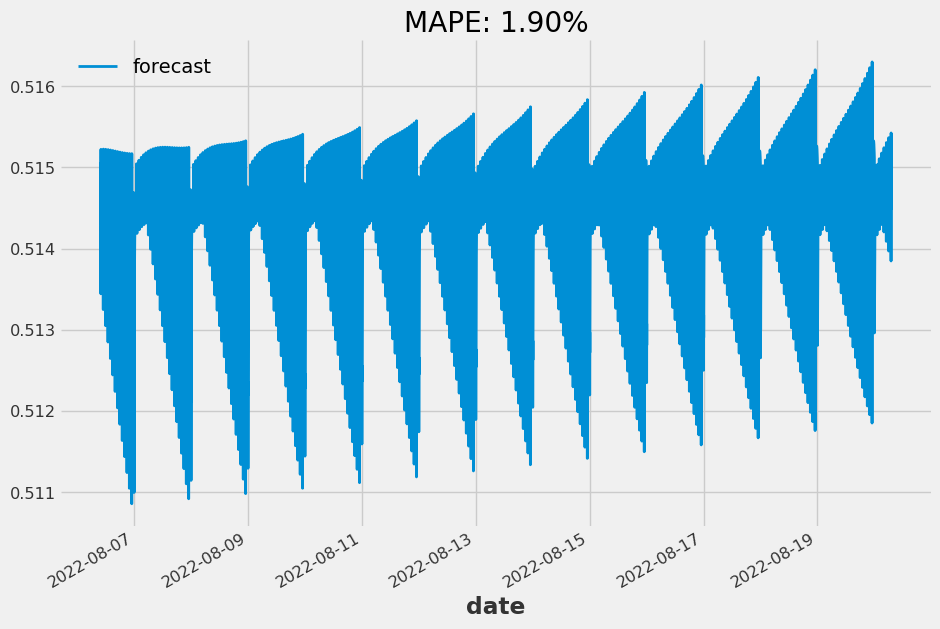

In [43]:
eval_model(rnn_model, 20000)

In [ ]:
encoders={
    'cyclic': {'future': ['month']},
    'datetime_attribute': {'future': ['hour', 'dayofweek']},
    'position': {'past': ['absolute'], 'future': ['relative']},
    'custom': {'past': [lambda idx: (idx.year - 1950) / 50]},
    'transformer': Scaler()
}

# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]
input_chunk_length = 60
forecast_horizon = 15
tft_model = TFTModel(
    model_name='TFTModel',
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=50,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0,
    batch_size=300,
    n_epochs=2,
    add_relative_index=False,
    add_encoders=None,
    #likelihood=QuantileRegression(
    #    quantiles=quantiles
    #),  # QuantileRegression is set per default
    #loss_fn=MAELoss(),
    pl_trainer_kwargs={'callbacks': [early_stopping_callback, model_checkpoint_callback, lr_monitor]},
    force_reset=True,
    save_checkpoints=True,
    log_tensorboard=True,
)

In [ ]:
model = tft_model.fit(rescaled_train, val_series=rescaled_test, future_covariates=covariates_transformed, val_future_covariates=covariates_transformed, verbose=True)

In [ ]:
# before starting, we define some constants
num_samples = 200

figsize = (10, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

In [ ]:
def eval_model(model, n, actual_series, val_series):
    pred_series = model.predict(n=n, num_samples=num_samples, future_covariates=covariates_transformed)
    #pred_series = pipeline.inverse_transform(pred_series)
    # plot actual series
    plt.figure(figsize=figsize)
    actual_series[: pred_series.end_time()].plot(label="actual")
    # plot prediction with quantile ranges
    pred_series.plot(low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer)
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)
    # Plot title
    plt.title('MAPE: {:.2f}%'.format(mape(val_series, pred_series)))
    plt.legend()

In [ ]:
prediction = eval_model(tft_model, 20000, rescaled_data, rescaled_test)